## Setup

In [1]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Function to set random seed
def set_random_seed(seed=42):
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
set_random_seed()

In [2]:
# Load the MNIST dataset
(data_train, labels_train), (data_test, labels_test) = tf.keras.datasets.mnist.load_data()

# Flatten the dataset
data_train = data_train.reshape(len(data_train), -1)
data_test = data_test.reshape(len(data_test), -1)

# Combine the dataset
data = np.r_[data_train, data_test]
labels = np.r_[labels_train, labels_test]

# Scale the inputs
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Create one-hot labels
binarizer = LabelBinarizer()
labels_one_hot = binarizer.fit_transform(labels)

# Shuffle the dataset
shuffled_indices = np.random.permutation(len(data))
data = data[shuffled_indices]
labels = labels[shuffled_indices]
labels_one_hot = labels_one_hot[shuffled_indices]

# Split the dataset
train_ratio = 0.9
split_index = int(train_ratio * len(data))
data_train = data[:split_index]
labels_train = labels[:split_index]
data_test = data[split_index:]
labels_test = labels[split_index:]
labels_train_one_hot = labels_one_hot[:split_index]
labels_test_one_hot = labels_one_hot[split_index:]

print(data_train.shape, labels_train.shape, data_test.shape, labels_test.shape)

/home/ice-bear/anaconda3/envs/machine_learning/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(63000, 784) (63000,) (7000, 784) (7000,)


In [3]:
# Generator to fetch a portion of the dataset(
def fetch_batch(X, y, batch_size):
    shuffled_indices = np.random.permutation(len(X))
    for i in range(0, len(X), batch_size):
        X_batch = X[shuffled_indices[i:i+batch_size]]
        y_batch = y[shuffled_indices[i:i+batch_size]]
        yield X_batch, y_batch

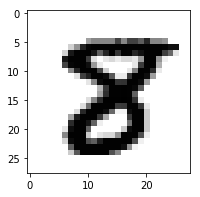

8


In [4]:
# Function to display one MNIST data
def plot_digit(x):
    plt.figure(figsize=(3,3))
    x = scaler.inverse_transform(x)
    x = x.reshape(28, 28)
    plt.imshow(x, cmap=matplotlib.cm.binary)
    plt.show()
    
plot_digit(data_train[0])
print(labels_train[0])

In [5]:
# The logistic function
def sigmoid(X):
    return 1.0 / (1.0 + np.exp(-X))

# The softmax function
def softmax(X, axis=-1):
    return np.exp(X) / np.sum(np.exp(X), axis=axis, keepdims=True)

## LeNet-5

In [6]:
class LeNet5:
    def __init__(self, learning_rate=0.1, momentum=0.5, dropout_rate=0.5):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.dropout_rate = dropout_rate
        
    def build_graph(self):
        # MNIST properties
        height = 28
        width = 28
        channels = 1
        input_size = height * width * channels
        output_size = 10
        
        # Build the graph
        self.graph = tf.Graph()
        with self.graph.as_default():
            # Make input placeholders
            self.X_ph = tf.placeholder(shape=(None, input_size), dtype=tf.float32)
            X_reshaped = tf.reshape(self.X_ph, shape=(-1, height, width, channels))
            self.y_ph = tf.placeholder(shape=(None,), dtype=tf.int32)
            self.train_ph = tf.placeholder(shape=(), dtype=tf.bool)
            
            # First convolutional layer
            X = tf.layers.conv2d(X_reshaped, filters=6, kernel_size=5, strides=1, 
                                 padding='SAME', activation=tf.nn.tanh)
            
            # First pooling layer
            X = tf.nn.avg_pool(X, ksize=(1,2,2,1), strides=(1,2,2,1), padding='VALID')
            
            # Second convolutional layer
            X = tf.layers.conv2d(X, filters=16, kernel_size=5, strides=1,
                                 padding='VALID', activation=tf.nn.tanh)
            
            # Second pooling layer
            X = tf.nn.avg_pool(X, ksize=(1,2,2,1), strides=(1,2,2,1), padding='VALID')
            
            # Third convolutional layer
            X = tf.layers.conv2d(X, filters=120, kernel_size=5, strides=1,
                                 padding='VALID', activation=tf.nn.tanh)
            
            # Fully connected layers
            X = tf.reshape(X, shape=(-1, 120))
            X = tf.layers.dropout(X, rate=self.dropout_rate, training=self.train_ph)
            X = tf.layers.dense(X, units=84, activation=tf.nn.tanh)
            X = tf.layers.dropout(X, rate=self.dropout_rate, training=self.train_ph)
            self.logits = tf.layers.dense(X, units=output_size)
            
            # Probabilities for each class
            self.probs = tf.nn.softmax(self.logits, axis=1)
            
            # Use mean cross entropy as the loss function
            cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=self.y_ph)
            self.loss = tf.reduce_mean(cross_entropy)
            
            # Make optimizer and train op
            optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=self.momentum)
            self.train_op = optimizer.minimize(self.loss)
            
            # Variables initializer
            self.init = tf.global_variables_initializer()
            
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.init)
            
        return self.graph
            
    def train(self, X, y, batch_size=100, n_epochs=1, show_progress=False):
        for epoch in range(n_epochs):
            # Perform mini-batch gradient descent using the entire dataset
            for X_batch, y_batch in fetch_batch(X, y, batch_size):
                self.sess.run(self.train_op, feed_dict={self.X_ph: X_batch, 
                                                        self.y_ph: y_batch, 
                                                        self.train_ph: True})
                
            if show_progress:
                prediction = self.predict(X[:1000])
                accuracy = sum(prediction == y[:1000]) / 1000
                print("Epoch: %d \t Train accuracy: %.3f" % (epoch, accuracy))
                    
    def predict(self, X):
        logits = self.sess.run(self.logits, feed_dict={self.X_ph: X, self.train_ph: False})
        return np.argmax(logits, axis=1)
        
    def get_probs(self, X):
        probs = self.sess.run(self.probs, feed_dict={self.X_ph: X, self.train_ph: False})
        return probs
    
    def reset_session(self):
        self.sess.close()
        self.sess = tf.Session(graph=self.graph)
            
    def __del__(self):
        self.sess.close()

In [7]:
set_random_seed(42)

lenet5 = LeNet5(learning_rate=0.1, momentum=0.5, dropout_rate=0.5)

lenet5.build_graph()

lenet5.train(data_train, labels_train, n_epochs=25, show_progress=True)

prediction = lenet5.predict(data_test)

print("Test accuracy:", sum(prediction==labels_test) / len(labels_test))

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
Epoch: 0 	 Train accuracy: 0.966
Epoch: 1 	 Train accuracy: 0.979
Epoch: 2 	 Train accuracy: 0.981
Epoch: 3 	 Train accuracy: 0.984
Epoch: 4 	 Train accuracy: 0.982
Epoch: 5 	 Train accuracy: 0.984
Epoch: 6 	 Train accuracy: 0.986
Epoch: 7 	 Train accuracy: 0.990
Epoch: 8 	 Train accuracy: 0.990
Epoch: 9 	 Train accuracy: 0.990
Epoch: 10 	 Train accuracy: 0.991
Epoch: 11 	 Train accuracy: 0.992
Epoch: 12 	 Train accuracy: 0.987
Epoch: 13 	 Train accuracy: 0.989
Epoch: 14 	 Train accuracy: 0.992
Epoch: 15 	 Train accuracy: 0.995
Epoch: 16 	 Train accuracy: 0.992
Epoch: 17 	 Train accuracy: 0.994
Epoch: 18 	 Train accuracy: 0.9

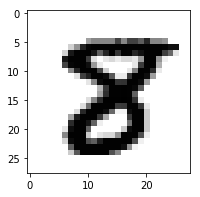

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


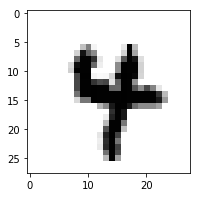

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


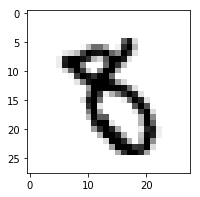

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


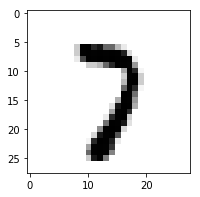

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


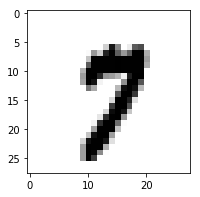

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [8]:
# Use the trained CNN to generate target probabilities
cnn_probs = lenet5.get_probs(data_train)

# Show some examples to make sure everything's okay
for i in range(5):
    plot_digit(data_train[i])
    print(np.around(cnn_probs[i],2))

## Soft Decision Tree

In [9]:
class SoftDecisionTree:
    def __init__(self, max_depth=8, learning_rate=0.1, inverse_temperature=1.0, 
                 reg_fn=lambda d: 2 ** -d, epsilon=1e-10):
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.inverse_temperature = inverse_temperature
        self.reg_fn = reg_fn
        self.epsilon = epsilon
    
    def build_graph(self):
        # MNIST properties
        input_size = 28 * 28
        output_size = 10
        
        # Create lists for storing parameters
        n_nodes = 2 ** (self.max_depth + 1)
        self.weights = [0] * n_nodes
        self.bias = [0] * n_nodes
        self.leaf_logits = [0] * n_nodes
        self.path_probs = [0] * n_nodes
        
        # Build the graph
        self.graph = tf.Graph()
        with self.graph.as_default():
            # Make input placeholders
            self.X_ph = tf.placeholder(shape=(None, input_size), dtype=tf.float32)
            self.y_ph = tf.placeholder(shape=(None, output_size), dtype=tf.float32)
            
            # Initialize the loss function
            self.loss = 0
            
            # Start building from the root node
            batch_size = tf.shape(self.X_ph)[0]
            self.path_probs[1] = tf.fill([batch_size], 1.0)
            self.build_node(self.X_ph, self.y_ph)
            
            # Finalize the loss function
            self.loss = -self.loss
            
            # Make optimizer and train op
            # optimizer = tf.train.MomentumOptimizer(learning_rate=self.learning_rate, momentum=self.momentum)
            optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            self.train_op = optimizer.minimize(self.loss)
            
            # Variables initializer
            self.init = tf.global_variables_initializer()
            
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.init)
            
        return self.graph
    
    def build_node(self, X, y, current_depth=1, index=1):
        if current_depth == self.max_depth:
            # Build a leaf node
            self.leaf_logits[index] = tf.Variable(initial_value=np.random.randn(y.shape[1], 1), dtype=tf.float32)
            
            probs = tf.nn.softmax(self.leaf_logits[index], axis=0)
            
            cross_entropy = tf.squeeze(tf.matmul(y, tf.log(probs)), axis=1)
            weighted_cross_entropy = tf.multiply(self.path_probs[index], cross_entropy)
            
            self.loss = self.loss + tf.reduce_mean(weighted_cross_entropy)
        else:
            # Build an internal node
            self.weights[index] = tf.Variable(initial_value=np.random.randn(X.shape[1], 1), dtype=tf.float32)
            self.bias[index] = tf.Variable(initial_value=0.0)
            
            logits = tf.matmul(X, self.weights[index]) + self.bias[index]
            
            probs = tf.squeeze(tf.sigmoid(self.inverse_temperature * logits), axis=1)
            
            left_index = 2 * index
            right_index = 2 * index + 1
            self.path_probs[left_index] = tf.multiply(self.path_probs[index], 1-probs)
            self.path_probs[right_index] = tf.multiply(self.path_probs[index], probs)
            
            # Add regularization term (balanced split)
            epsilon = tf.constant(self.epsilon)  # small constant to prevent division by zero/log of zero
            reg_term = self.reg_fn(current_depth)
            left_ratio = tf.reduce_sum(self.path_probs[left_index]) / (tf.reduce_sum(self.path_probs[index]) + epsilon)
            right_ratio = tf.reduce_sum(self.path_probs[right_index]) / (tf.reduce_sum(self.path_probs[index]) + epsilon)
            
            self.loss = self.loss + reg_term * (0.5 * tf.log(left_ratio + epsilon) + 0.5 * tf.log(right_ratio + epsilon))
            
            # Build left and right subtrees
            self.build_node(X, y, current_depth+1, left_index)
            self.build_node(X, y, current_depth+1, right_index)
            
    def train(self, X, y, batch_size=100, n_epochs=1, show_progress=False):
        for epoch in range(n_epochs):
            # Perform mini-batch gradient descent using the entire dataset
            for X_batch, y_batch in fetch_batch(X, y, batch_size):
                # Skip last batch if it's small
                self.sess.run(self.train_op, feed_dict={self.X_ph: X_batch, self.y_ph: y_batch})
                
            if show_progress:
                loss = self.sess.run(self.loss, feed_dict={self.X_ph: X, self.y_ph: y})
                print("Epoch: %d \t Loss: %.3f" % (epoch, loss))
                   
    def get_logits_local(self, X, current_depth=1, index=1):
        # At each internal node, split the samples into two based on the 
        # computed probability at that node only
        # print("Logits local")
        if len(X) == 0:
            return None
        elif current_depth == self.max_depth:
            # At leaf node: simply return the logits for every sample
            logits = self.sess.run(self.leaf_logits[index])
            logits = logits.ravel()
            return [logits for _ in range(len(X))]
        else:
            # At internal node: split the dataset, get the logits of each, and then combine them
            weights, bias = self.sess.run([self.weights[index], self.bias[index]])
            
            logits = np.dot(X, weights) + bias
            # print("Max logits", np.max(logits))
            probs = np.squeeze(sigmoid(self.inverse_temperature * logits), axis=1)
            
            mask = np.array(probs < 0.5)
            
            indices_left = np.nonzero(mask)
            indices_right = np.nonzero(np.logical_not(mask))
            
            logits_left = self.get_logits_local(X[indices_left], current_depth+1, index*2)
            logits_right = self.get_logits_local(X[indices_right], current_depth+1, index*2+1)
            
            logits = []
            it_left, it_right = 0, 0
            for m in mask:
                if m:
                    logits.append(logits_left[it_left])
                    it_left += 1
                else:
                    logits.append(logits_right[it_right])
                    it_right += 1
            
            return logits
        
    def get_logits_indices_global(self, X, path_probs, current_depth=1, index=1):
        # print("Indices global")
        # For every sample, compute the probability of reaching each leaf node and then
        # return the index of the leaf with the highest path probability
        if len(X) == 0:
            return None
        elif current_depth == self.max_depth:
            # At leaf node: return path probabilities and the leaf index
            indices = np.full(len(X), index)
            return path_probs, indices
        else:
            # At internal node: get the path_probs and indices from both child nodes, then
            # combine them by taking the max prob for each sample
            weights, bias = self.sess.run([self.weights[index], self.bias[index]])
            
            logits = np.dot(X, weights) + bias
            probs = np.squeeze(sigmoid(self.inverse_temperature * logits), axis=1)
            
            path_probs_left = np.multiply(path_probs, 1-probs)
            path_probs_right = np.multiply(path_probs, probs)
            
            probs_left, indices_left = self.get_logits_indices_global(
                X, path_probs_left, current_depth+1, index*2)
            probs_right, indices_right = self.get_logits_indices_global(
                X, path_probs_right, current_depth+1, index*2+1)
            
            indices = np.where(probs_left > probs_right, indices_left, indices_right)
            probs = np.maximum(probs_left, probs_right)
            
            return probs, indices
        
    def get_logits_global(self, X):
        root_probs = np.full((len(X)), 1.0)
        probs, indices = self.get_logits_indices_global(X, root_probs)
        logits = []
        for index in indices:
            logits.append(self.sess.run(self.leaf_logits[index]).ravel())
        return logits
    
    def get_probs_global(self, X, path_probs, current_depth=1, index=1):
        # print("Probs global")
        # For every sample, compute the probability of being every target at every
        # leaf node, then add them all up
        if len(X) == 0:
            return None
        elif current_depth == self.max_depth:
            # At leaf node: return target probabilities at this leaf node
            logits = self.sess.run(self.leaf_logits[index])
            probs = np.dot(path_probs.reshape(-1, 1), softmax(logits.reshape(1, -1)))
            return probs
        else:
            # At internal node: get the probabilities from both child nodes and add them together
            weights, bias = self.sess.run([self.weights[index], self.bias[index]])
            
            logits = np.dot(X, weights) + bias
            probs = np.squeeze(sigmoid(self.inverse_temperature * logits), axis=1)
            
            path_probs_left = np.multiply(path_probs, 1-probs)
            path_probs_right = np.multiply(path_probs, probs)
            
            probs_left = self.get_probs_global(X, path_probs_left, current_depth+1, index*2)
            probs_right = self.get_probs_global(X, path_probs_right, current_depth+1, index*2+1)
            
            return probs_left + probs_right
    
    def predict(self, X, method=1):
        if method == 1:
            logits = self.get_logits_local(X)
            return np.argmax(logits, axis=1)
        elif method == 2:
            logits = self.get_logits_global(X)
            return np.argmax(logits, axis=1)
        elif method == 3:
            root_probs = np.full((len(X)), 1.0)
            probs = self.get_probs_global(X, root_probs)
            return np.argmax(probs, axis=1)
        else:
            return None
        
    def get_probs(self, X, current_depth=1, index=1):
        if method == 1:
            logits = self.get_logits_local(X)
            return softmax(logits, axis=1)
        elif method == 2:
            logits = self.get_logits_global(X)
            return softmax(logits, axis=1)
        elif method == 3:
            root_probs = np.full((len(X)), 1.0)
            probs = self.get_probs_global(X, root_probs)
            return probs
        else:
            return None
        
    def compute_loss(self, X, y):
        return self.sess.run(self.loss, feed_dict={self.X_ph: X, self.y_ph: y})
    
    def visualize_parameters(self, index):
        weights, bias = self.sess.run([self.weights[index], self.bias[index]])
        plot_digit(weights + bias)
    
    def reset_session(self):
        if self.sess:
            self.sess.close()
        self.sess = tf.Session(graph=self.graph)
            
    def __del__(self):
        if self.sess:
            self.sess.close()

In [10]:
# Measure performance of the model using only the raw data

set_random_seed(42)
t = time.time()

tree = SoftDecisionTree()

tree.build_graph()

tree.train(data_train, labels_train_one_hot, batch_size=256, n_epochs=50, show_progress=True)

print("Time to train model: %.3f s\n" % (time.time() - t))

print("Train loss", tree.compute_loss(data_train, labels_train_one_hot))

for predict_method in [1, 2, 3]:
    print("Method = %d" % (predict_method))

    # Compute training accuracy
    prediction = tree.predict(data_train, method=predict_method)
    train_accuracy = sum(prediction == labels_train) / len(prediction)

    # Compute test accuracy
    prediction = tree.predict(data_test, method=predict_method)
    test_accuracy = sum(prediction == labels_test) / len(prediction)

    # Compute loss
    loss = tree.compute_loss(data_test, labels_test_one_hot)

    print("Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
          (train_accuracy, test_accuracy, loss))

Epoch: 0 	 Loss: 3.576
Epoch: 1 	 Loss: 3.527
Epoch: 2 	 Loss: 3.428
Epoch: 3 	 Loss: 3.426
Epoch: 4 	 Loss: 3.443
Epoch: 5 	 Loss: 3.475
Epoch: 6 	 Loss: 3.456
Epoch: 7 	 Loss: 3.403
Epoch: 8 	 Loss: 3.434
Epoch: 9 	 Loss: 3.450
Epoch: 10 	 Loss: 3.397
Epoch: 11 	 Loss: 3.383
Epoch: 12 	 Loss: 3.424
Epoch: 13 	 Loss: 3.409
Epoch: 14 	 Loss: 3.392
Epoch: 15 	 Loss: 3.383
Epoch: 16 	 Loss: 3.339
Epoch: 17 	 Loss: 3.332
Epoch: 18 	 Loss: 3.356
Epoch: 19 	 Loss: 3.395
Epoch: 20 	 Loss: 3.365
Epoch: 21 	 Loss: 3.333
Epoch: 22 	 Loss: 3.369
Epoch: 23 	 Loss: 3.360
Epoch: 24 	 Loss: 3.343
Epoch: 25 	 Loss: 3.340
Epoch: 26 	 Loss: 3.287
Epoch: 27 	 Loss: 3.325
Epoch: 28 	 Loss: 3.279
Epoch: 29 	 Loss: 3.332
Epoch: 30 	 Loss: 3.291
Epoch: 31 	 Loss: 3.271
Epoch: 32 	 Loss: 3.279
Epoch: 33 	 Loss: 3.242
Epoch: 34 	 Loss: 3.249
Epoch: 35 	 Loss: 3.264
Epoch: 36 	 Loss: 3.251
Epoch: 37 	 Loss: 3.264
Epoch: 38 	 Loss: 3.253
Epoch: 39 	 Loss: 3.289
Epoch: 40 	 Loss: 3.266
Epoch: 41 	 Loss: 3.262
Ep

In [11]:
# Measure performance of the model using the data generated by the CNN

set_random_seed(42)
t = time.time()

tree = SoftDecisionTree()

tree.build_graph()

tree.train(data_train, cnn_probs, batch_size=256, n_epochs=50, show_progress=True)

print("Time to train model: %.3f s\n" % (time.time() - t))

print("Train loss", tree.compute_loss(data_train, cnn_probs))

for predict_method in [1, 2, 3]:
    print("Method = %d" % (predict_method))

    # Compute training accuracy
    prediction = tree.predict(data_train, method=predict_method)
    train_accuracy = sum(prediction == labels_train) / len(prediction)

    # Compute test accuracy
    prediction = tree.predict(data_test, method=predict_method)
    test_accuracy = sum(prediction == labels_test) / len(prediction)

    # Compute loss
    loss = tree.compute_loss(data_test, labels_test_one_hot)

    print("Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
          (train_accuracy, test_accuracy, loss))

Epoch: 0 	 Loss: 3.646
Epoch: 1 	 Loss: 3.535
Epoch: 2 	 Loss: 3.464
Epoch: 3 	 Loss: 3.398
Epoch: 4 	 Loss: 3.360
Epoch: 5 	 Loss: 3.336
Epoch: 6 	 Loss: 3.339
Epoch: 7 	 Loss: 3.339
Epoch: 8 	 Loss: 3.360
Epoch: 9 	 Loss: 3.378
Epoch: 10 	 Loss: 3.336
Epoch: 11 	 Loss: 3.329
Epoch: 12 	 Loss: 3.343
Epoch: 13 	 Loss: 3.340
Epoch: 14 	 Loss: 3.306
Epoch: 15 	 Loss: 3.297
Epoch: 16 	 Loss: 3.346
Epoch: 17 	 Loss: 3.334
Epoch: 18 	 Loss: 3.329
Epoch: 19 	 Loss: 3.329
Epoch: 20 	 Loss: 3.349
Epoch: 21 	 Loss: 3.360
Epoch: 22 	 Loss: 3.410
Epoch: 23 	 Loss: 3.418
Epoch: 24 	 Loss: 3.376
Epoch: 25 	 Loss: 3.363
Epoch: 26 	 Loss: 3.327
Epoch: 27 	 Loss: 3.333
Epoch: 28 	 Loss: 3.345
Epoch: 29 	 Loss: 3.338
Epoch: 30 	 Loss: 3.318
Epoch: 31 	 Loss: 3.305
Epoch: 32 	 Loss: 3.264
Epoch: 33 	 Loss: 3.300
Epoch: 34 	 Loss: 3.291
Epoch: 35 	 Loss: 3.271
Epoch: 36 	 Loss: 3.279
Epoch: 37 	 Loss: 3.270
Epoch: 38 	 Loss: 3.271
Epoch: 39 	 Loss: 3.265
Epoch: 40 	 Loss: 3.298
Epoch: 41 	 Loss: 3.285
Ep

In [ ]:
# Try various depths

for depth in [5, 6, 7, 8, 9, 10]:
    print("Using cnn data, depth = %d" % (depth))
    
    t = time.time()
    
    set_random_seed(42)
    
    tree = SoftDecisionTree(max_depth=depth)
    
    tree.build_graph()
    
    tree.train(data_train, cnn_probs, batch_size=256, n_epochs=25, show_progress=True)
    
    print("Time to train model: %.3f s\n" % (time.time() - t))
    
    print("Train loss", tree.compute_loss(data_train, cnn_probs))
    
    for predict_method in [1, 2, 3]:
        print("Method = %d" % (predict_method))
        
        # Compute training accuracy
        prediction = tree.predict(data_train, method=predict_method)
        train_accuracy = sum(prediction == labels_train) / len(prediction)
        
        # Compute test accuracy
        prediction = tree.predict(data_test, method=predict_method)
        test_accuracy = sum(prediction == labels_test) / len(prediction)
        
        # Compute loss
        loss = tree.compute_loss(data_test, labels_test_one_hot)

        print("Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
              (train_accuracy, test_accuracy, loss))

Using cnn data, depth = 5
Epoch: 0 	 Loss: 2.178
Epoch: 1 	 Loss: 2.117
Epoch: 2 	 Loss: 2.088
Epoch: 3 	 Loss: 2.031
Epoch: 4 	 Loss: 2.028
Epoch: 5 	 Loss: 2.027
Epoch: 6 	 Loss: 2.000
Epoch: 7 	 Loss: 2.009
Epoch: 8 	 Loss: 2.006
Epoch: 9 	 Loss: 1.974
Epoch: 10 	 Loss: 1.961
Epoch: 11 	 Loss: 1.967
Epoch: 12 	 Loss: 1.959
Epoch: 13 	 Loss: 1.957
Epoch: 14 	 Loss: 1.958
Epoch: 15 	 Loss: 1.959
Epoch: 16 	 Loss: 1.949
Epoch: 17 	 Loss: 1.956
Epoch: 18 	 Loss: 1.948
Epoch: 19 	 Loss: 1.945
Epoch: 20 	 Loss: 1.949
Epoch: 21 	 Loss: 1.951
Epoch: 22 	 Loss: 1.939
Epoch: 23 	 Loss: 1.936
Epoch: 24 	 Loss: 1.933
Time to train model: 73.084 s

Train loss 1.9325297
Method = 1
Train accuracy: 0.882 	 Test accuracy: 0.876 	 Loss: 1.970

Method = 2
Train accuracy: 0.882 	 Test accuracy: 0.876 	 Loss: 1.970

Method = 3
Train accuracy: 0.882 	 Test accuracy: 0.876 	 Loss: 1.970

Using cnn data, depth = 6
Epoch: 0 	 Loss: 2.502
Epoch: 1 	 Loss: 2.426
Epoch: 2 	 Loss: 2.367
Epoch: 3 	 Loss: 2.368
E

In [ ]:
# Try various learning rates

for learning_rate in [0.05, 0.1, 0.5, 1.0, 1.5, 2.0]:
    print("Using cnn data, learning rate = %.2f" % (learning_rate))
    
    t = time.time()
    
    set_random_seed(42)
    
    tree = SoftDecisionTree(learning_rate=learning_rate)
    
    tree.build_graph()
    
    tree.train(data_train, cnn_probs, batch_size=256, n_epochs=25, show_progress=True)
    
    print("Time to train model: %.3f s\n" % (time.time() - t))
    
    print("Train loss", tree.compute_loss(data_train, cnn_probs))
    
    for predict_method in [1, 2, 3]:
        print("Method = %d" % (predict_method))
        
        # Compute training accuracy
        prediction = tree.predict(data_train, method=predict_method)
        train_accuracy = sum(prediction == labels_train) / len(prediction)
        
        # Compute test accuracy
        prediction = tree.predict(data_test, method=predict_method)
        test_accuracy = sum(prediction == labels_test) / len(prediction)
        
        # Compute loss
        loss = tree.compute_loss(data_test, labels_test_one_hot)

        print("Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
              (train_accuracy, test_accuracy, loss))

Using cnn data, learning rate = 0.05
Epoch: 0 	 Loss: 3.416
Epoch: 1 	 Loss: 3.256
Epoch: 2 	 Loss: 3.198
Epoch: 3 	 Loss: 3.122
Epoch: 4 	 Loss: 3.134
Epoch: 5 	 Loss: 3.134
Epoch: 6 	 Loss: 3.152
Epoch: 7 	 Loss: 3.142
Epoch: 8 	 Loss: 3.119
Epoch: 9 	 Loss: 3.090
Epoch: 10 	 Loss: 3.089
Epoch: 11 	 Loss: 3.098
Epoch: 12 	 Loss: 3.101
Epoch: 13 	 Loss: 3.033
Epoch: 14 	 Loss: 3.045
Epoch: 15 	 Loss: 3.017
Epoch: 16 	 Loss: 3.033
Epoch: 17 	 Loss: 3.021
Epoch: 18 	 Loss: 3.036
Epoch: 19 	 Loss: 3.011
Epoch: 20 	 Loss: 3.008
Epoch: 21 	 Loss: 3.032
Epoch: 22 	 Loss: 3.000
Epoch: 23 	 Loss: 3.018
Epoch: 24 	 Loss: 2.995
Time to train model: 509.258 s

Train loss 2.9954898
Method = 1
Train accuracy: 0.863 	 Test accuracy: 0.856 	 Loss: 3.043

Method = 2
Train accuracy: 0.863 	 Test accuracy: 0.856 	 Loss: 3.043

Method = 3
Train accuracy: 0.871 	 Test accuracy: 0.862 	 Loss: 3.043

Using cnn data, learning rate = 0.10
Epoch: 0 	 Loss: 3.646
Epoch: 1 	 Loss: 3.535
Epoch: 2 	 Loss: 3.464
E

In [ ]:
# Try various inverse temperatures

for inverse_temperature in [0.05, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    print("Using cnn data, inverse temperature = %.1f" % (inverse_temperature))
    
    t = time.time()
    
    set_random_seed(42)
    
    tree = SoftDecisionTree(inverse_temperature=inverse_temperature)
    
    tree.build_graph()
    
    tree.train(data_train, cnn_probs, batch_size=256, n_epochs=25, show_progress=True)
    
    print("Time to train model: %.3f s\n" % (time.time() - t))
    
    print("Train loss", tree.compute_loss(data_train, cnn_probs))
    
    for predict_method in [1, 2, 3]:
        print("Method = %d" % (predict_method))
        
        # Compute training accuracy
        prediction = tree.predict(data_train, method=predict_method)
        train_accuracy = sum(prediction == labels_train) / len(prediction)
        
        # Compute test accuracy
        prediction = tree.predict(data_test, method=predict_method)
        test_accuracy = sum(prediction == labels_test) / len(prediction)
        
        # Compute loss
        loss = tree.compute_loss(data_test, labels_test_one_hot)

        print("Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
              (train_accuracy, test_accuracy, loss))

Using cnn data, inverse temperature = 0.1
Epoch: 0 	 Loss: 2.802
Epoch: 1 	 Loss: 2.725
Epoch: 2 	 Loss: 2.697
Epoch: 3 	 Loss: 2.677
Epoch: 4 	 Loss: 2.667
Epoch: 5 	 Loss: 2.650
Epoch: 6 	 Loss: 2.642
Epoch: 7 	 Loss: 2.634
Epoch: 8 	 Loss: 2.625
Epoch: 9 	 Loss: 2.626
Epoch: 10 	 Loss: 2.616
Epoch: 11 	 Loss: 2.613
Epoch: 12 	 Loss: 2.610
Epoch: 13 	 Loss: 2.611
Epoch: 14 	 Loss: 2.603
Epoch: 15 	 Loss: 2.605
Epoch: 16 	 Loss: 2.599
Epoch: 17 	 Loss: 2.598
Epoch: 18 	 Loss: 2.596
Epoch: 19 	 Loss: 2.597
Epoch: 20 	 Loss: 2.590
Epoch: 21 	 Loss: 2.592
Epoch: 22 	 Loss: 2.587
Epoch: 23 	 Loss: 2.591
Epoch: 24 	 Loss: 2.588
Time to train model: 509.428 s

Train loss 2.5881126
Method = 1
Train accuracy: 0.974 	 Test accuracy: 0.944 	 Loss: 2.766

Method = 2
Train accuracy: 0.974 	 Test accuracy: 0.944 	 Loss: 2.766

Method = 3
Train accuracy: 0.976 	 Test accuracy: 0.947 	 Loss: 2.766

Using cnn data, inverse temperature = 0.1
Epoch: 0 	 Loss: 2.836
Epoch: 1 	 Loss: 2.769
Epoch: 2 	 Los

In [10]:
# Try various regularization strength

for r in [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]:
    print("Using cnn data, regularization strength = %.1f" % (r))
    
    t = time.time()
    
    set_random_seed(42)
    
    tree = SoftDecisionTree(reg_fn=lambda d: r ** -d)
    
    tree.build_graph()
    
    tree.train(data_train, cnn_probs, batch_size=256, n_epochs=25, show_progress=True)
    
    print("Time to train model: %.3f s\n" % (time.time() - t))
    
    print("Train loss", tree.compute_loss(data_train, cnn_probs))
    
    for predict_method in [1, 2, 3]:
        print("Method = %d" % (predict_method))
        
        # Compute training accuracy
        prediction = tree.predict(data_train, method=predict_method)
        train_accuracy = sum(prediction == labels_train) / len(prediction)
        
        # Compute test accuracy
        prediction = tree.predict(data_test, method=predict_method)
        test_accuracy = sum(prediction == labels_test) / len(prediction)
        
        # Compute loss
        loss = tree.compute_loss(data_test, labels_test_one_hot)

        print("Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
              (train_accuracy, test_accuracy, loss))

Using cnn data, regularization strength = 1.0
Epoch: 0 	 Loss: 94.108
Epoch: 1 	 Loss: 93.185
Epoch: 2 	 Loss: 91.612
Epoch: 3 	 Loss: 91.372
Epoch: 4 	 Loss: 91.593
Epoch: 5 	 Loss: 91.858
Epoch: 6 	 Loss: 91.286
Epoch: 7 	 Loss: 91.366
Epoch: 8 	 Loss: 91.702
Epoch: 9 	 Loss: 91.491
Epoch: 10 	 Loss: 91.268
Epoch: 11 	 Loss: 91.711
Epoch: 12 	 Loss: 91.721
Epoch: 13 	 Loss: 91.495
Epoch: 14 	 Loss: 91.524
Epoch: 15 	 Loss: 91.074
Epoch: 16 	 Loss: 91.431
Epoch: 17 	 Loss: 91.523
Epoch: 18 	 Loss: 91.330
Epoch: 19 	 Loss: 91.092
Epoch: 20 	 Loss: 91.330
Epoch: 21 	 Loss: 91.204
Epoch: 22 	 Loss: 90.972
Epoch: 23 	 Loss: 91.764
Epoch: 24 	 Loss: 91.364
Time to train model: 538.041 s

Train loss 91.36372
Method = 1
Train accuracy: 0.442 	 Test accuracy: 0.441 	 Loss: 91.674

Method = 2
Train accuracy: 0.442 	 Test accuracy: 0.441 	 Loss: 91.674

Method = 3
Train accuracy: 0.451 	 Test accuracy: 0.451 	 Loss: 91.674

Using cnn data, regularization strength = 1.5
Epoch: 0 	 Loss: 10.749
E

In [11]:
# Test the model using the raw data

set_random_seed(42)
t = time.time()

tree = SoftDecisionTree(max_depth = 8,
                        learning_rate = 0.01,
                        inverse_temperature = 0.1,
                        reg_fn = lambda d: 4 ** -d)

tree.build_graph()

tree.train(data_train, labels_train_one_hot, batch_size=256, n_epochs=50, show_progress=True)

print("Time to train model: %.3f s\n" % (time.time() - t))

print("Train loss", tree.compute_loss(data_train, labels_train_one_hot))

for predict_method in [1, 2, 3]:
    print("Method = %d" % (predict_method))

    # Compute training accuracy
    prediction = tree.predict(data_train, method=predict_method)
    train_accuracy = sum(prediction == labels_train) / len(prediction)

    # Compute test accuracy
    prediction = tree.predict(data_test, method=predict_method)
    test_accuracy = sum(prediction == labels_test) / len(prediction)

    # Compute loss
    loss = tree.compute_loss(data_test, labels_test_one_hot)

    print("Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
          (train_accuracy, test_accuracy, loss))

Epoch: 0 	 Loss: 0.952
Epoch: 1 	 Loss: 0.770
Epoch: 2 	 Loss: 0.693
Epoch: 3 	 Loss: 0.647
Epoch: 4 	 Loss: 0.613
Epoch: 5 	 Loss: 0.589
Epoch: 6 	 Loss: 0.570
Epoch: 7 	 Loss: 0.554
Epoch: 8 	 Loss: 0.542
Epoch: 9 	 Loss: 0.530
Epoch: 10 	 Loss: 0.521
Epoch: 11 	 Loss: 0.512
Epoch: 12 	 Loss: 0.505
Epoch: 13 	 Loss: 0.497
Epoch: 14 	 Loss: 0.491
Epoch: 15 	 Loss: 0.486
Epoch: 16 	 Loss: 0.481
Epoch: 17 	 Loss: 0.476
Epoch: 18 	 Loss: 0.471
Epoch: 19 	 Loss: 0.467
Epoch: 20 	 Loss: 0.463
Epoch: 21 	 Loss: 0.460
Epoch: 22 	 Loss: 0.457
Epoch: 23 	 Loss: 0.453
Epoch: 24 	 Loss: 0.451
Epoch: 25 	 Loss: 0.448
Epoch: 26 	 Loss: 0.445
Epoch: 27 	 Loss: 0.443
Epoch: 28 	 Loss: 0.441
Epoch: 29 	 Loss: 0.439
Epoch: 30 	 Loss: 0.436
Epoch: 31 	 Loss: 0.435
Epoch: 32 	 Loss: 0.433
Epoch: 33 	 Loss: 0.431
Epoch: 34 	 Loss: 0.429
Epoch: 35 	 Loss: 0.428
Epoch: 36 	 Loss: 0.426
Epoch: 37 	 Loss: 0.425
Epoch: 38 	 Loss: 0.424
Epoch: 39 	 Loss: 0.423
Epoch: 40 	 Loss: 0.421
Epoch: 41 	 Loss: 0.420
Ep

In [12]:
# Test the model using the probabilities generated by the CNN

set_random_seed(42)
t = time.time()

tree = SoftDecisionTree(max_depth = 8,
                        learning_rate = 0.01,
                        inverse_temperature = 0.1,
                        reg_fn = lambda d: 4 ** -d)

tree.build_graph()

tree.train(data_train, cnn_probs, batch_size=256, n_epochs=50, show_progress=True)

print("Time to train model: %.3f s\n" % (time.time() - t))

print("Train loss", tree.compute_loss(data_train, cnn_probs))

for predict_method in [1, 2, 3]:
    print("Method = %d" % (predict_method))

    # Compute training accuracy
    prediction = tree.predict(data_train, method=predict_method)
    train_accuracy = sum(prediction == labels_train) / len(prediction)

    # Compute test accuracy
    prediction = tree.predict(data_test, method=predict_method)
    test_accuracy = sum(prediction == labels_test) / len(prediction)

    # Compute loss
    loss = tree.compute_loss(data_test, labels_test_one_hot)

    print("Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
          (train_accuracy, test_accuracy, loss))

Epoch: 0 	 Loss: 0.947
Epoch: 1 	 Loss: 0.764
Epoch: 2 	 Loss: 0.687
Epoch: 3 	 Loss: 0.642
Epoch: 4 	 Loss: 0.609
Epoch: 5 	 Loss: 0.586
Epoch: 6 	 Loss: 0.567
Epoch: 7 	 Loss: 0.552
Epoch: 8 	 Loss: 0.540
Epoch: 9 	 Loss: 0.529
Epoch: 10 	 Loss: 0.520
Epoch: 11 	 Loss: 0.512
Epoch: 12 	 Loss: 0.505
Epoch: 13 	 Loss: 0.498
Epoch: 14 	 Loss: 0.492
Epoch: 15 	 Loss: 0.487
Epoch: 16 	 Loss: 0.482
Epoch: 17 	 Loss: 0.478
Epoch: 18 	 Loss: 0.474
Epoch: 19 	 Loss: 0.470
Epoch: 20 	 Loss: 0.467
Epoch: 21 	 Loss: 0.464
Epoch: 22 	 Loss: 0.461
Epoch: 23 	 Loss: 0.458
Epoch: 24 	 Loss: 0.455
Epoch: 25 	 Loss: 0.452
Epoch: 26 	 Loss: 0.450
Epoch: 27 	 Loss: 0.448
Epoch: 28 	 Loss: 0.446
Epoch: 29 	 Loss: 0.444
Epoch: 30 	 Loss: 0.442
Epoch: 31 	 Loss: 0.441
Epoch: 32 	 Loss: 0.439
Epoch: 33 	 Loss: 0.438
Epoch: 34 	 Loss: 0.436
Epoch: 35 	 Loss: 0.435
Epoch: 36 	 Loss: 0.433
Epoch: 37 	 Loss: 0.432
Epoch: 38 	 Loss: 0.431
Epoch: 39 	 Loss: 0.430
Epoch: 40 	 Loss: 0.429
Epoch: 41 	 Loss: 0.428
Ep

In [11]:
set_random_seed(42)
t = time.time()

tree = SoftDecisionTree(max_depth = 7,
                        learning_rate = 0.01,
                        inverse_temperature = 0.1,
                        reg_fn = lambda d: 4 ** -d)

tree.build_graph()

n_epochs = 50
for epoch in range(n_epochs):
    tree.train(data_train, cnn_probs, batch_size=256)
    
    # Compute training accuracy
    prediction = tree.predict(data_train, method=3)
    train_accuracy = sum(prediction == labels_train) / len(prediction)

    # Compute test accuracy
    prediction = tree.predict(data_test, method=3)
    test_accuracy = sum(prediction == labels_test) / len(prediction)

    # Compute loss
    loss = tree.compute_loss(data_test, labels_test_one_hot)

    print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
          (epoch, train_accuracy, test_accuracy, loss))

Epoch: 0 	 Train accuracy: 0.892 	 Test accuracy: 0.896 	 Loss: 1.021

Epoch: 1 	 Train accuracy: 0.927 	 Test accuracy: 0.922 	 Loss: 0.839

Epoch: 2 	 Train accuracy: 0.936 	 Test accuracy: 0.929 	 Loss: 0.773

Epoch: 3 	 Train accuracy: 0.943 	 Test accuracy: 0.933 	 Loss: 0.740

Epoch: 4 	 Train accuracy: 0.947 	 Test accuracy: 0.935 	 Loss: 0.717

Epoch: 5 	 Train accuracy: 0.949 	 Test accuracy: 0.937 	 Loss: 0.702

Epoch: 6 	 Train accuracy: 0.952 	 Test accuracy: 0.940 	 Loss: 0.693

Epoch: 7 	 Train accuracy: 0.954 	 Test accuracy: 0.941 	 Loss: 0.684

Epoch: 8 	 Train accuracy: 0.956 	 Test accuracy: 0.940 	 Loss: 0.680

Epoch: 9 	 Train accuracy: 0.958 	 Test accuracy: 0.942 	 Loss: 0.675

Epoch: 10 	 Train accuracy: 0.960 	 Test accuracy: 0.943 	 Loss: 0.673

Epoch: 11 	 Train accuracy: 0.961 	 Test accuracy: 0.943 	 Loss: 0.672

Epoch: 12 	 Train accuracy: 0.962 	 Test accuracy: 0.943 	 Loss: 0.669

Epoch: 13 	 Train accuracy: 0.963 	 Test accuracy: 0.944 	 Loss: 0.668

Ep

In [12]:
set_random_seed(42)
t = time.time()

tree = SoftDecisionTree(max_depth = 8,
                        learning_rate = 0.01,
                        inverse_temperature = 0.1,
                        reg_fn = lambda d: 4 ** -d)

tree.build_graph()

n_epochs = 50
for epoch in range(n_epochs):
    tree.train(data_train, cnn_probs, batch_size=256)
    
    # Compute training accuracy
    prediction = tree.predict(data_train, method=3)
    train_accuracy = sum(prediction == labels_train) / len(prediction)

    # Compute test accuracy
    prediction = tree.predict(data_test, method=3)
    test_accuracy = sum(prediction == labels_test) / len(prediction)

    # Compute loss
    loss = tree.compute_loss(data_test, labels_test_one_hot)

    print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
          (epoch, train_accuracy, test_accuracy, loss))

Epoch: 0 	 Train accuracy: 0.910 	 Test accuracy: 0.908 	 Loss: 0.960

Epoch: 1 	 Train accuracy: 0.939 	 Test accuracy: 0.935 	 Loss: 0.794

Epoch: 2 	 Train accuracy: 0.951 	 Test accuracy: 0.942 	 Loss: 0.730

Epoch: 3 	 Train accuracy: 0.958 	 Test accuracy: 0.946 	 Loss: 0.693

Epoch: 4 	 Train accuracy: 0.962 	 Test accuracy: 0.950 	 Loss: 0.672

Epoch: 5 	 Train accuracy: 0.965 	 Test accuracy: 0.950 	 Loss: 0.656

Epoch: 6 	 Train accuracy: 0.968 	 Test accuracy: 0.952 	 Loss: 0.644

Epoch: 7 	 Train accuracy: 0.970 	 Test accuracy: 0.954 	 Loss: 0.634

Epoch: 8 	 Train accuracy: 0.972 	 Test accuracy: 0.957 	 Loss: 0.630

Epoch: 9 	 Train accuracy: 0.973 	 Test accuracy: 0.955 	 Loss: 0.626

Epoch: 10 	 Train accuracy: 0.974 	 Test accuracy: 0.958 	 Loss: 0.621

Epoch: 11 	 Train accuracy: 0.975 	 Test accuracy: 0.958 	 Loss: 0.620

Epoch: 12 	 Train accuracy: 0.976 	 Test accuracy: 0.958 	 Loss: 0.617

Epoch: 13 	 Train accuracy: 0.977 	 Test accuracy: 0.957 	 Loss: 0.620

Ep

In [13]:
set_random_seed(42)
t = time.time()

tree = SoftDecisionTree(max_depth = 9,
                        learning_rate = 0.01,
                        inverse_temperature = 0.1,
                        reg_fn = lambda d: 4 ** -d)

tree.build_graph()

n_epochs = 50
for epoch in range(n_epochs):
    tree.train(data_train, cnn_probs, batch_size=256)
    
    # Compute training accuracy
    prediction = tree.predict(data_train, method=3)
    train_accuracy = sum(prediction == labels_train) / len(prediction)

    # Compute test accuracy
    prediction = tree.predict(data_test, method=3)
    test_accuracy = sum(prediction == labels_test) / len(prediction)

    # Compute loss
    loss = tree.compute_loss(data_test, labels_test_one_hot)

    print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
          (epoch, train_accuracy, test_accuracy, loss))

Epoch: 0 	 Train accuracy: 0.918 	 Test accuracy: 0.922 	 Loss: 0.923

Epoch: 1 	 Train accuracy: 0.944 	 Test accuracy: 0.941 	 Loss: 0.768

Epoch: 2 	 Train accuracy: 0.954 	 Test accuracy: 0.946 	 Loss: 0.705

Epoch: 3 	 Train accuracy: 0.961 	 Test accuracy: 0.952 	 Loss: 0.672

Epoch: 4 	 Train accuracy: 0.967 	 Test accuracy: 0.954 	 Loss: 0.650

Epoch: 5 	 Train accuracy: 0.970 	 Test accuracy: 0.954 	 Loss: 0.635

Epoch: 6 	 Train accuracy: 0.973 	 Test accuracy: 0.957 	 Loss: 0.623

Epoch: 7 	 Train accuracy: 0.976 	 Test accuracy: 0.958 	 Loss: 0.614

Epoch: 8 	 Train accuracy: 0.978 	 Test accuracy: 0.959 	 Loss: 0.608

Epoch: 9 	 Train accuracy: 0.979 	 Test accuracy: 0.959 	 Loss: 0.602

Epoch: 10 	 Train accuracy: 0.980 	 Test accuracy: 0.961 	 Loss: 0.600

Epoch: 11 	 Train accuracy: 0.982 	 Test accuracy: 0.961 	 Loss: 0.596

Epoch: 12 	 Train accuracy: 0.982 	 Test accuracy: 0.962 	 Loss: 0.594

Epoch: 13 	 Train accuracy: 0.983 	 Test accuracy: 0.961 	 Loss: 0.592

Ep

In [15]:
# Try various depths

for depth in [6, 7, 8, 9, 10]:
    print("Using cnn data, depth = %d" % (depth))
    
    set_random_seed(42)
    
    tree = SoftDecisionTree(max_depth = depth,
                            learning_rate = 0.01,
                            inverse_temperature = 0.1,
                            reg_fn = lambda d: 4 ** -d)
    
    tree.build_graph()
    
    n_epochs = 30
    for epoch in range(n_epochs):
        tree.train(data_train, cnn_probs, batch_size=256)

        # Compute training accuracy
        prediction = tree.predict(data_train, method=3)
        train_accuracy = sum(prediction == labels_train) / len(prediction)

        # Compute test accuracy
        prediction = tree.predict(data_test, method=3)
        test_accuracy = sum(prediction == labels_test) / len(prediction)

        # Compute loss
        loss = tree.compute_loss(data_test, labels_test_one_hot)

        print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
              (epoch, train_accuracy, test_accuracy, loss))

Using cnn data, depth = 6


Exception ignored in: <bound method SoftDecisionTree.__del__ of <__main__.SoftDecisionTree object at 0x7f510f145ac8>>
Traceback (most recent call last):
  File "<ipython-input-9-590cfb14dd5a>", line 246, in __del__
AttributeError: 'SoftDecisionTree' object has no attribute 'sess'


Epoch: 0 	 Train accuracy: 0.879 	 Test accuracy: 0.877 	 Loss: 1.095

Epoch: 1 	 Train accuracy: 0.914 	 Test accuracy: 0.908 	 Loss: 0.899

Epoch: 2 	 Train accuracy: 0.924 	 Test accuracy: 0.917 	 Loss: 0.828

Epoch: 3 	 Train accuracy: 0.931 	 Test accuracy: 0.920 	 Loss: 0.792

Epoch: 4 	 Train accuracy: 0.934 	 Test accuracy: 0.923 	 Loss: 0.773

Epoch: 5 	 Train accuracy: 0.938 	 Test accuracy: 0.927 	 Loss: 0.758

Epoch: 6 	 Train accuracy: 0.940 	 Test accuracy: 0.927 	 Loss: 0.749

Epoch: 7 	 Train accuracy: 0.942 	 Test accuracy: 0.929 	 Loss: 0.740

Epoch: 8 	 Train accuracy: 0.943 	 Test accuracy: 0.929 	 Loss: 0.735

Epoch: 9 	 Train accuracy: 0.944 	 Test accuracy: 0.929 	 Loss: 0.730

Epoch: 10 	 Train accuracy: 0.944 	 Test accuracy: 0.928 	 Loss: 0.725

Epoch: 11 	 Train accuracy: 0.945 	 Test accuracy: 0.930 	 Loss: 0.722

Epoch: 12 	 Train accuracy: 0.947 	 Test accuracy: 0.931 	 Loss: 0.720

Epoch: 13 	 Train accuracy: 0.947 	 Test accuracy: 0.930 	 Loss: 0.716

Ep

Epoch: 24 	 Train accuracy: 0.988 	 Test accuracy: 0.964 	 Loss: 0.596

Epoch: 25 	 Train accuracy: 0.988 	 Test accuracy: 0.964 	 Loss: 0.596

Epoch: 26 	 Train accuracy: 0.989 	 Test accuracy: 0.963 	 Loss: 0.597

Epoch: 27 	 Train accuracy: 0.989 	 Test accuracy: 0.963 	 Loss: 0.596

Epoch: 28 	 Train accuracy: 0.989 	 Test accuracy: 0.964 	 Loss: 0.599

Epoch: 29 	 Train accuracy: 0.989 	 Test accuracy: 0.962 	 Loss: 0.600

Using cnn data, depth = 10
Epoch: 0 	 Train accuracy: 0.924 	 Test accuracy: 0.926 	 Loss: 0.883

Epoch: 1 	 Train accuracy: 0.949 	 Test accuracy: 0.945 	 Loss: 0.735

Epoch: 2 	 Train accuracy: 0.960 	 Test accuracy: 0.951 	 Loss: 0.677

Epoch: 3 	 Train accuracy: 0.967 	 Test accuracy: 0.956 	 Loss: 0.646

Epoch: 4 	 Train accuracy: 0.972 	 Test accuracy: 0.960 	 Loss: 0.627

Epoch: 5 	 Train accuracy: 0.975 	 Test accuracy: 0.961 	 Loss: 0.613

Epoch: 6 	 Train accuracy: 0.978 	 Test accuracy: 0.963 	 Loss: 0.604

Epoch: 7 	 Train accuracy: 0.981 	 Test accu

In [16]:
# Try various inverse_temperature

for temperature in [0.01, 0.05, 0.1, 0.2, 0.4]:
    print("Using cnn data, temperature = %.2f" % (temperature))
    
    set_random_seed(42)
    
    tree = SoftDecisionTree(max_depth = 8,
                            learning_rate = 0.01,
                            inverse_temperature = temperature,
                            reg_fn = lambda d: 4 ** -d)
    
    tree.build_graph()
    
    n_epochs = 30
    for epoch in range(n_epochs):
        tree.train(data_train, cnn_probs, batch_size=256)

        # Compute training accuracy
        prediction = tree.predict(data_train, method=3)
        train_accuracy = sum(prediction == labels_train) / len(prediction)

        # Compute test accuracy
        prediction = tree.predict(data_test, method=3)
        test_accuracy = sum(prediction == labels_test) / len(prediction)

        # Compute loss
        loss = tree.compute_loss(data_test, labels_test_one_hot)

        print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
              (epoch, train_accuracy, test_accuracy, loss))

Using cnn data, temperature = 0.01
Epoch: 0 	 Train accuracy: 0.740 	 Test accuracy: 0.734 	 Loss: 1.760

Epoch: 1 	 Train accuracy: 0.867 	 Test accuracy: 0.866 	 Loss: 1.326

Epoch: 2 	 Train accuracy: 0.900 	 Test accuracy: 0.899 	 Loss: 1.130

Epoch: 3 	 Train accuracy: 0.915 	 Test accuracy: 0.912 	 Loss: 1.023

Epoch: 4 	 Train accuracy: 0.924 	 Test accuracy: 0.922 	 Loss: 0.953

Epoch: 5 	 Train accuracy: 0.931 	 Test accuracy: 0.928 	 Loss: 0.903

Epoch: 6 	 Train accuracy: 0.936 	 Test accuracy: 0.932 	 Loss: 0.865

Epoch: 7 	 Train accuracy: 0.940 	 Test accuracy: 0.935 	 Loss: 0.835

Epoch: 8 	 Train accuracy: 0.943 	 Test accuracy: 0.937 	 Loss: 0.811

Epoch: 9 	 Train accuracy: 0.945 	 Test accuracy: 0.939 	 Loss: 0.791

Epoch: 10 	 Train accuracy: 0.947 	 Test accuracy: 0.940 	 Loss: 0.775

Epoch: 11 	 Train accuracy: 0.949 	 Test accuracy: 0.942 	 Loss: 0.760

Epoch: 12 	 Train accuracy: 0.951 	 Test accuracy: 0.944 	 Loss: 0.747

Epoch: 13 	 Train accuracy: 0.952 	 Tes

Epoch: 23 	 Train accuracy: 0.981 	 Test accuracy: 0.948 	 Loss: 0.661

Epoch: 24 	 Train accuracy: 0.981 	 Test accuracy: 0.949 	 Loss: 0.663

Epoch: 25 	 Train accuracy: 0.981 	 Test accuracy: 0.950 	 Loss: 0.660

Epoch: 26 	 Train accuracy: 0.982 	 Test accuracy: 0.949 	 Loss: 0.665

Epoch: 27 	 Train accuracy: 0.982 	 Test accuracy: 0.950 	 Loss: 0.664

Epoch: 28 	 Train accuracy: 0.982 	 Test accuracy: 0.949 	 Loss: 0.667

Epoch: 29 	 Train accuracy: 0.982 	 Test accuracy: 0.950 	 Loss: 0.668

Using cnn data, temperature = 0.40
Epoch: 0 	 Train accuracy: 0.867 	 Test accuracy: 0.864 	 Loss: 0.998

Epoch: 1 	 Train accuracy: 0.913 	 Test accuracy: 0.902 	 Loss: 0.821

Epoch: 2 	 Train accuracy: 0.928 	 Test accuracy: 0.915 	 Loss: 0.759

Epoch: 3 	 Train accuracy: 0.940 	 Test accuracy: 0.925 	 Loss: 0.727

Epoch: 4 	 Train accuracy: 0.947 	 Test accuracy: 0.926 	 Loss: 0.707

Epoch: 5 	 Train accuracy: 0.952 	 Test accuracy: 0.931 	 Loss: 0.687

Epoch: 6 	 Train accuracy: 0.956 	 

In [17]:
# Try various regularization strengths

for strength in [2, 3, 4, 5, 6]:
    print("Using cnn data, strength = %d" % (strength))
    
    set_random_seed(42)
    
    tree = SoftDecisionTree(max_depth = 8,
                            learning_rate = 0.01,
                            inverse_temperature = 0.1,
                            reg_fn = lambda d: strength ** -d)
    
    tree.build_graph()
    
    n_epochs = 30
    for epoch in range(n_epochs):
        tree.train(data_train, cnn_probs, batch_size=256)

        # Compute training accuracy
        prediction = tree.predict(data_train, method=3)
        train_accuracy = sum(prediction == labels_train) / len(prediction)

        # Compute test accuracy
        prediction = tree.predict(data_test, method=3)
        test_accuracy = sum(prediction == labels_test) / len(prediction)

        # Compute loss
        loss = tree.compute_loss(data_test, labels_test_one_hot)

        print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
              (epoch, train_accuracy, test_accuracy, loss))

Using cnn data, strength = 2
Epoch: 0 	 Train accuracy: 0.913 	 Test accuracy: 0.910 	 Loss: 3.238

Epoch: 1 	 Train accuracy: 0.935 	 Test accuracy: 0.929 	 Loss: 2.972

Epoch: 2 	 Train accuracy: 0.944 	 Test accuracy: 0.934 	 Loss: 2.889

Epoch: 3 	 Train accuracy: 0.950 	 Test accuracy: 0.940 	 Loss: 2.850

Epoch: 4 	 Train accuracy: 0.954 	 Test accuracy: 0.939 	 Loss: 2.831

Epoch: 5 	 Train accuracy: 0.958 	 Test accuracy: 0.942 	 Loss: 2.814

Epoch: 6 	 Train accuracy: 0.960 	 Test accuracy: 0.943 	 Loss: 2.806

Epoch: 7 	 Train accuracy: 0.962 	 Test accuracy: 0.944 	 Loss: 2.797

Epoch: 8 	 Train accuracy: 0.963 	 Test accuracy: 0.945 	 Loss: 2.792

Epoch: 9 	 Train accuracy: 0.964 	 Test accuracy: 0.945 	 Loss: 2.785

Epoch: 10 	 Train accuracy: 0.965 	 Test accuracy: 0.947 	 Loss: 2.782

Epoch: 11 	 Train accuracy: 0.966 	 Test accuracy: 0.945 	 Loss: 2.779

Epoch: 12 	 Train accuracy: 0.966 	 Test accuracy: 0.946 	 Loss: 2.778

Epoch: 13 	 Train accuracy: 0.967 	 Test accu

Epoch: 23 	 Train accuracy: 0.981 	 Test accuracy: 0.955 	 Loss: 0.506

Epoch: 24 	 Train accuracy: 0.981 	 Test accuracy: 0.955 	 Loss: 0.507

Epoch: 25 	 Train accuracy: 0.982 	 Test accuracy: 0.955 	 Loss: 0.507

Epoch: 26 	 Train accuracy: 0.982 	 Test accuracy: 0.954 	 Loss: 0.509

Epoch: 27 	 Train accuracy: 0.982 	 Test accuracy: 0.955 	 Loss: 0.510

Epoch: 28 	 Train accuracy: 0.983 	 Test accuracy: 0.954 	 Loss: 0.512

Epoch: 29 	 Train accuracy: 0.983 	 Test accuracy: 0.954 	 Loss: 0.512

Using cnn data, strength = 6
Epoch: 0 	 Train accuracy: 0.908 	 Test accuracy: 0.907 	 Loss: 0.774

Epoch: 1 	 Train accuracy: 0.937 	 Test accuracy: 0.931 	 Loss: 0.607

Epoch: 2 	 Train accuracy: 0.948 	 Test accuracy: 0.941 	 Loss: 0.546

Epoch: 3 	 Train accuracy: 0.955 	 Test accuracy: 0.945 	 Loss: 0.513

Epoch: 4 	 Train accuracy: 0.959 	 Test accuracy: 0.948 	 Loss: 0.492

Epoch: 5 	 Train accuracy: 0.963 	 Test accuracy: 0.949 	 Loss: 0.478

Epoch: 6 	 Train accuracy: 0.965 	 Test a

In [18]:
# Try various learning rates

for rate in [0.001, 0.005, 0.01, 0.02, 0.05]:
    print("Using cnn data, learning rate = %.3f" % (rate))
    
    set_random_seed(42)
    
    tree = SoftDecisionTree(max_depth = 8,
                            learning_rate = rate,
                            inverse_temperature = 0.1,
                            reg_fn = lambda d: 4 ** -d)
    
    tree.build_graph()
    
    n_epochs = 30
    for epoch in range(n_epochs):
        tree.train(data_train, cnn_probs, batch_size=256)

        # Compute training accuracy
        prediction = tree.predict(data_train, method=3)
        train_accuracy = sum(prediction == labels_train) / len(prediction)

        # Compute test accuracy
        prediction = tree.predict(data_test, method=3)
        test_accuracy = sum(prediction == labels_test) / len(prediction)

        # Compute loss
        loss = tree.compute_loss(data_test, labels_test_one_hot)

        print("Epoch: %d \t Train accuracy: %.3f \t Test accuracy: %.3f \t Loss: %.3f\n" % 
              (epoch, train_accuracy, test_accuracy, loss))

Using cnn data, learning rate = 0.001
Epoch: 0 	 Train accuracy: 0.589 	 Test accuracy: 0.596 	 Loss: 2.285

Epoch: 1 	 Train accuracy: 0.709 	 Test accuracy: 0.709 	 Loss: 1.862

Epoch: 2 	 Train accuracy: 0.785 	 Test accuracy: 0.787 	 Loss: 1.592

Epoch: 3 	 Train accuracy: 0.839 	 Test accuracy: 0.842 	 Loss: 1.394

Epoch: 4 	 Train accuracy: 0.872 	 Test accuracy: 0.873 	 Loss: 1.252

Epoch: 5 	 Train accuracy: 0.889 	 Test accuracy: 0.890 	 Loss: 1.150

Epoch: 6 	 Train accuracy: 0.900 	 Test accuracy: 0.901 	 Loss: 1.076

Epoch: 7 	 Train accuracy: 0.907 	 Test accuracy: 0.908 	 Loss: 1.021

Epoch: 8 	 Train accuracy: 0.913 	 Test accuracy: 0.912 	 Loss: 0.978

Epoch: 9 	 Train accuracy: 0.917 	 Test accuracy: 0.917 	 Loss: 0.944

Epoch: 10 	 Train accuracy: 0.921 	 Test accuracy: 0.919 	 Loss: 0.915

Epoch: 11 	 Train accuracy: 0.925 	 Test accuracy: 0.923 	 Loss: 0.891

Epoch: 12 	 Train accuracy: 0.928 	 Test accuracy: 0.926 	 Loss: 0.870

Epoch: 13 	 Train accuracy: 0.931 	 

Epoch: 23 	 Train accuracy: 0.986 	 Test accuracy: 0.958 	 Loss: 0.627

Epoch: 24 	 Train accuracy: 0.986 	 Test accuracy: 0.956 	 Loss: 0.627

Epoch: 25 	 Train accuracy: 0.986 	 Test accuracy: 0.957 	 Loss: 0.627

Epoch: 26 	 Train accuracy: 0.987 	 Test accuracy: 0.956 	 Loss: 0.630

Epoch: 27 	 Train accuracy: 0.987 	 Test accuracy: 0.956 	 Loss: 0.632

Epoch: 28 	 Train accuracy: 0.987 	 Test accuracy: 0.956 	 Loss: 0.637

Epoch: 29 	 Train accuracy: 0.987 	 Test accuracy: 0.956 	 Loss: 0.638

Using cnn data, learning rate = 0.050
Epoch: 0 	 Train accuracy: 0.947 	 Test accuracy: 0.935 	 Loss: 0.709

Epoch: 1 	 Train accuracy: 0.959 	 Test accuracy: 0.948 	 Loss: 0.647

Epoch: 2 	 Train accuracy: 0.967 	 Test accuracy: 0.947 	 Loss: 0.633

Epoch: 3 	 Train accuracy: 0.971 	 Test accuracy: 0.954 	 Loss: 0.620

Epoch: 4 	 Train accuracy: 0.973 	 Test accuracy: 0.953 	 Loss: 0.614

Epoch: 5 	 Train accuracy: 0.975 	 Test accuracy: 0.954 	 Loss: 0.613

Epoch: 6 	 Train accuracy: 0.976